In [55]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import eig
import pandas as pd
import scipy.linalg as la
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.metrics.pairwise import polynomial_kernel, cosine_similarity
from sklearn.metrics.pairwise import sigmoid_kernel, linear_kernel
from sklearn.metrics.pairwise import laplacian_kernel
from scipy.optimize import minimize
import pdb
import tensorflow as tf
from kdpp import kDPP
np.random.seed(1) #Fix the seed
print ("Packages loaded.")

Packages loaded.


# 1) Introduction to DPP : a very simple example
We would like to test our kdpp class for a very simple example in two dimension

In [2]:
# Gaussian Kernel
def kernel_se(_X1,_X2,_hyp={'gain':1,'len':1,'noise':1e-8}):
    hyp_gain = float(_hyp['gain'])**2
    hyp_len  = 1/float(_hyp['len'])
    pairwise_dists = cdist(_X1,_X2,'euclidean')
    K = hyp_gain*np.exp(-pairwise_dists ** 2 / (hyp_len**2))
    return K

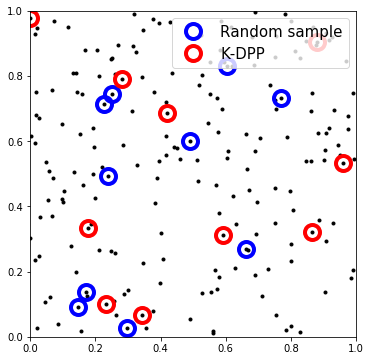

In [3]:
# Data
n = 200
k = 10
x = np.random.rand(n,2)

# K-DPP and randomm sample 
kdpp = kDPP(x, kernel_se)
kdpp_out,_ = kdpp.sample(k = k)
rand_out = x[np.random.permutation(n)[:k],:]

# Plot
plt.figure(figsize=(6,6))
plt.plot(x[:,0],x[:,1],'k.')
hr, = plt.plot(rand_out[:,0],rand_out[:,1],marker='o',mec='blue',mfc='None',markersize=15,linestyle='None',mew=4)
hk, = plt.plot(kdpp_out[:,0],kdpp_out[:,1],marker='o',mec='red',mfc='None',markersize=15,linestyle='None',mew=4)
plt.xlim(0.0,1.0); plt.ylim(0.0,1.0)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend([hr,hk],['Random sample','K-DPP'],fontsize=15,loc='upper right')
plt.show()

# 2) Kernels definition
We want to compare the efficiency of the algorithm with different kernels. We define them here (or recall the function call for sklearn kernels

In [75]:
def angular(X1, X2, *args):
    def Gort(G):
        Q, R = np.linalg.qr(G)
        return Q
    Gort = Gort(np.random.normal(size=(len(X1),len(X1))))
    phi1 = 1/np.sqrt(len(X1))*np.sign(np.dot(Gort,X1))
    phi2 = 1/np.sqrt(len(X2))*np.sign(np.dot(Gort,X2))
    return np.dot(phi1,phi2.T)

# sklearn kernels : cosine_similarity(X1,X2), polynomial_kernel(X1,X2), 
# laplacian_kernel(X1,X2), sigmoid_kernel(X1,X2), angular(X1,X2), linear_kernel(X1,X2)

# 3) Building and training the network

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
def network(data=mnist, learning_rate = 0.05, epochs = 30,
                batch_size = 100, hidden1 = 500, hidden2 = 500):
    '''
    Creates a 2 layers fully connected neural network
    '''
    # declare the training data placeholders
    # input x - for 28 x 28 pixels = 784
    x = tf.placeholder(tf.float32, [None, 784])
    # now declare the output data placeholder - 10 digits
    y = tf.placeholder(tf.float32, [None, 10])

    # now declare the weights connecting the input to the hidden layer
    W1 = tf.Variable(tf.random_normal([784, hidden1], stddev=0.03), name='W1')
    b1 = tf.Variable(tf.random_normal([hidden1]), name='b1')
    # the weights connecting the hidden layer to the other hidden layer
    W2 = tf.Variable(tf.random_normal([hidden1, hidden2], stddev=0.03), name='W2')
    b2 = tf.Variable(tf.random_normal([hidden2]), name='b2')
    # and the weights connecting the hidden layer to the output layer
    W3 = tf.Variable(tf.random_normal([hidden2, 10], stddev=0.03), name='W2')
    b3 = tf.Variable(tf.random_normal([10]), name='b2')

    # calculate the output of the hidden layers
    hidden_out_1 = tf.add(tf.matmul(x, W1), b1)
    hidden_out_1 = tf.nn.relu(hidden_out_1)
    hidden_out_2 = tf.nn.relu(tf.add(tf.matmul(hidden_out_1, W2), b2))
    # now calculate the hidden layer output - in this case, let's use a softmax activated
    # output layer
    y_ = tf.nn.softmax(tf.add(tf.matmul(hidden_out_2, W3), b3))


    #Compute cross entropy
    y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999) # Being sure we don't have ln(0)
    cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)
                             + (1 - y) * tf.log(1 - y_clipped), axis=1))

    # add an optimiser
    optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

    # finally setup the initialisation operator
    init_op = tf.global_variables_initializer()

    # define an accuracy assessment operation
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # start the session
    with tf.Session() as sess:
        # initialise the variables
        sess.run(init_op)
        total_batch = int(len(data.train.labels) / batch_size)
        for epoch in range(epochs):
            avg_cost = 0
            for i in range(total_batch):
                batch_x, batch_y = data.train.next_batch(batch_size=batch_size)
                _, c = sess.run([optimiser, cross_entropy], 
                             feed_dict={x: batch_x, y: batch_y})
                avg_cost += c / total_batch
            print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))
        print(sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))
        Weights1 = sess.run(W1)
        Weights2 = sess.run(W2)
        Weights3 = sess.run(W3)
        bias1 = sess.run(b1)
        bias2 = sess.run(b2)
        bias3 = sess.run(b3)
    parameters = [(Weights1, bias1), (Weights2, bias2), (Weights3, bias3)]
    return parameters

# 4) Neural Network compression procedure
We start by giving the rebuild_act_labels function which compute the activation vector of each neurons of a layer

In [7]:
def rebuild_act_labels_mean(Weights1,  Weights2, bias1, bias2):
    #Rebuild the activations:
    act_layer1 = np.zeros((10,len(bias1)))
    act_layer2 = np.zeros((10,len(bias2)))
    
    for i in range(len(mnist.train.images)):
        act_layer1[np.argmax(mnist.train.labels[i]),:] += np.maximum(
            0,(np.dot(Weights1.T, mnist.train.images[i]) + bias1))
        act_layer2[np.argmax(mnist.train.labels[i]),:] += np.maximum(
            0,(np.dot(Weights2.T, act_layer1[np.argmax(mnist.train.labels[i]),:] ) + bias2))
        
    for i in range(10):
        count = np.sum(i == np.argmax(mnist.train.labels, axis = 1))
        act_layer1[i,:] /= count
        act_layer2[i,:] /= count
        
    return act_layer1, act_layer2

In [8]:
def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    
    Rows are scores for each class. 
    Columns are predictions (samples).
    """
    scoreMatExp = np.exp(np.asarray(x))
    return scoreMatExp / scoreMatExp.sum(0)

In [9]:
def rebuild_act_labels_im(Weights1, Weights2, Weights3, bias1, bias2, bias3, idx_f):
    #Rebuild the activations:
    act_layer1 = np.zeros((len(idx_f),len(bias1)))
    act_layer2 = np.zeros((len(idx_f),len(bias2)))
    act_layer3 = np.zeros((len(idx_f),len(bias3)))
    
    for i in range(len(idx_f)):
        act_layer1[i,:] = np.maximum(
            0,(np.dot(Weights1.T, mnist.train.images[idx_f[i]]) + bias1))
        act_layer2[i,:] = np.maximum(
            0,(np.dot(Weights2.T, act_layer1[i, :]) + bias2))
        act_layer3[i,:] = softmax(
            np.dot(Weights3.T, act_layer2[i, :]) + bias3)
    return act_layer1, act_layer2, act_layer3

Split the neurons we keep and the one we drop

In [10]:
def prune_neurons(idx, layer, parameters):
    '''
    idx : (list) : list of the chosen index with kdpp
    layer (int) : layer considered
    parameters (ndarray,ndarray) : weights and bias of the considered layer'''
    #Split weights between the ones we keep and the ones we drop
    #Prune for the first layer
    weights_prev, bias_prev = parameters[layer - 1]
    weights_cur, bias_cur = parameters[layer] #weights of the layer

    new_weights_prev = weights_prev[:, idx]
    drop_idx = list()
    for i in np.arange(weights_cur.shape[0]):
        if i not in idx:
            drop_idx += [i]
    new_weights_cur = weights_cur[idx]
    new_bias_prev = bias_prev[idx]
    drop_weights = weights_cur[drop_idx]

    new_parameters = parameters.copy()
    new_parameters[layer - 1] = (new_weights_prev, new_bias_prev)
    new_parameters[layer] = (new_weights_cur, bias_cur)
        
    
    return new_parameters, drop_idx, drop_weights

Reweighting procedure

In [11]:
def reweight(layer, activations, new_parameters, idx, drop_idx, drop_weights):
    '''
    idx : (list) : list of the chosen index with kdpp
    activations (list) : activations vectors for each layers
    layer (int) : layer considered
    parameters (ndarray,ndarray) : weights and bias of the considered layer
    idx (list) : chosen index with kdpp
    drop_idx (list) : index of the non-chosen neurons'''
    
    act_idx = activations[0]
    act_layer = activations[layer]
    act_layer_aft = activations[layer + 1]
    weights_cur, bias_cur = new_parameters[layer]
    alpha = np.empty((len(act_idx),len(drop_idx) ))
    drop_acti = act_layer[drop_idx]
    
    def proj1(alpha, ind, v1 = drop_acti, v2 = act_idx):
        return np.linalg.norm(v1[ind] - np.dot(alpha, v2))
    
    alpha_results = []
    for i in range(len(drop_idx)):
        if i%50 == 0:
            print("step", i)
        alpha_results += [minimize(proj1, np.random.random(len(act_idx)), (i))]
    
    for i in range(len(drop_idx)):
        alpha[:, i] = alpha_results[i]['x']

    #Now fuse the dropped weights within the kept ones   
    new_weights_cur = weights_cur.copy()
    for i in range(weights_cur.shape[0]):
        add_weights = np.dot(alpha, drop_weights)
        for j in range(weights_cur.shape[1]):
            new_weights_cur[i][j] += add_weights[i][j]
            
    new_parameters = new_parameters.copy()
    new_parameters[layer] = (new_weights_cur, bias_cur)
    
    return new_parameters

# 5) Experiments
### a) Find the best kernel

In [12]:
parameters = network()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch: 1 cost = 1.084
Epoch: 2 cost = 0.481
Epoch: 3 cost = 0.377
Epoch: 4 cost = 0.306
Epoch: 5 cost = 0.255
Epoch: 6 cost = 0.219
Epoch: 7 cost = 0.188
Epoch: 8 cost = 0.165
Epoch: 9 cost = 0.144
Epoch: 10 cost = 0.128
Epoch: 11 cost = 0.115
Epoch: 12 cost = 0.102
Epoch: 13 cost = 0.092
Epoch: 14 cost = 0.084
Epoch: 15 cost = 0.075
Epoch: 16 cost = 0.068
Epoch: 17 cost = 0.060
Epoch: 18 cost = 0.055
Epoch: 19 cost = 0.050
Epoch: 20 cost = 0.044
Epoch: 21 cost = 0.041
Epoch: 22 cost = 0.035
Epoch: 23 cost = 0.032
Epoch: 24 cost = 0.029
Epoch: 25 cost = 0.026
Epoch: 26 cost = 0.024
Epoch: 27 cost = 0.021
Epoch: 28 cost = 0.019
Epoch: 29 cost = 0.017
Epoch: 30 cost = 0.015
0.9802


In [33]:
Weights1, bias1 = parameters[0]
Weights2, bias2 = parameters[1]
Weights3, bias3 = parameters[2]

k_f = 1100
kddpf = kDPP(mnist.train.images[:3300], kernel_se)
act_f, idx_f = kddpf.sample(k_f)

/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


In [123]:
layer = 1
k_1 = 250
act_layer1, act_layer2, act_layer3 = rebuild_act_labels_im(Weights1,  Weights2, Weights3, bias1, bias2, bias3, idx_f)
kdpp1 = kDPP(act_layer1.T, kernel_se)
act_idx1, idx1 = kdpp1.sample(k_1)
new_parameters1, drop_idx, drop_weights = prune_neurons(idx1, layer, parameters)

In [127]:
activations = np.array([act_idx1, act_layer1.T, act_layer2.T, act_layer3.T])
new_parameters1 = reweight(layer, activations, new_parameters1, idx1, drop_idx, drop_weights)

(250, 1100)
(250, 1100)
(250, 250)
step 0
step 50
step 100
step 150
step 200


In [142]:
layer = 2
k_2 = 250
kdpp2 = kDPP(act_layer2.T, kernel_se)
act_idx2, idx2 = kdpp2.sample(k_2)
new_parameters2, drop_idx, drop_weights = prune_neurons(idx2, layer, new_parameters1)

In [143]:
activations = np.array([act_idx2, act_layer1.T, act_layer2.T, act_layer3.T])
new_parameters2 = reweight(layer, activations, new_parameters2, idx2, drop_idx, drop_weights)

step 0
step 50
step 100
step 150
step 200


In [14]:
def new_nets(new_parameters, learning_rate = 0.05, epochs = 1, batch_size = 100):
    new_weights1, new_bias1 = new_parameters[0]
    new_weights2, new_bias2 = new_parameters[1]
    new_weights3, new_bias3 = new_parameters[2]
    # declare the training data placeholders
    # input x - for 28 x 28 pixels = 784
    x = tf.placeholder(tf.float32, [None, 784])
    # now declare the output data placeholder - 10 digits
    y = tf.placeholder(tf.float32, [None, 10])

    # now declare the weights connecting the input to the hidden layer
    init_W1 = tf.constant(new_weights1, dtype=tf.float32)
    W1 = tf.Variable(init_W1, name='W1', trainable = False)
    init_b1 = tf.constant(new_bias1, dtype=tf.float32)
    b1 = tf.Variable(init_b1, name='b1', trainable = False)
    # the weights connecting the hidden layer to the other hidden layer
    init_W2 = tf.constant(new_weights2, dtype=tf.float32)
    W2 = tf.Variable(init_W2, name='W2', trainable = False)
    init_b2 = tf.constant(new_bias2, dtype=tf.float32)
    b2 = tf.Variable(init_b2, name='b2', trainable = False)
    # and the weights connecting the hidden layer to the output layer
    init_W3 = tf.constant(new_weights3, dtype=tf.float32)
    W3 = tf.Variable(init_W3, name='W3', trainable = False)
    init_b3 = tf.constant(new_bias3, dtype=tf.float32)
    b3 = tf.Variable(init_b3, name='b3')

    # calculate the output of the hidden layers
    hidden_out_1 = tf.add(tf.matmul(x, W1), b1)
    hidden_out_1 = tf.nn.relu(hidden_out_1)
    hidden_out_2 = tf.nn.relu(tf.add(tf.matmul(hidden_out_1, W2), b2))
    # now calculate the hidden layer output - in this case, let's use a softmax activated
    # output layer
    y_ = tf.nn.softmax(tf.add(tf.matmul(hidden_out_2, W3), b3))


    #Compute cross entropy
    y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999) # Being sure we don't have ln(0)
    cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)
                             + (1 - y) * tf.log(1 - y_clipped), axis=1))

    # add an optimiser
    optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

    # finally setup the initialisation operator
    init_op = tf.global_variables_initializer()

    # define an accuracy assessment operation
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    with tf.Session() as sess:
        sess.run(init_op)
        acc = sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})
    return acc

#new_nets(new_parameters2)

#### Put everything in one function:


In [1]:
Weights1, bias1 = parameters[0]
Weights2, bias2 = parameters[1]
Weights3, bias3 = parameters[2]

def sampling_fea(k_f, kernel):
    
    print("begin kdpp over features")
    kddpf = kDPP(mnist.train.images[:3300], kernel)
    act_f, idx_f = kddpf.sample(k_f)
    print("end kdpp over features")
    
    return idx_f

def results(idx_f, k_1, k_2, kernel, Weights1 = Weights1,  Weights2 = Weights2, Weights3 = Weights3, bias1 = bias1, bias2 = bias2, bias3 = bias3):
    
    print("begin pruning for layer 1")
    layer = 1
    act_layer1, act_layer2, act_layer3 = rebuild_act_labels_im(Weights1,  Weights2, Weights3, bias1, bias2, bias3, idx_f)
    kdpp1 = kDPP(act_layer1.T, kernel)
    act_idx1, idx1 = kdpp1.sample(k_1)
    new_parameters1, drop_idx, drop_weights = prune_neurons(idx1, layer, parameters)
    print("end pruning for layer 1")
    
    print("begin reweighting for layer 1")
    activations = np.array([act_idx1, act_layer1.T, act_layer2.T, act_layer3.T])
    new_parameters1 = reweight(layer, activations, new_parameters1, idx1, drop_idx, drop_weights)
    print("end reweighting for layer 1")
    
#     print("begin pruning for layer 2")
#     layer = 2
#     kdpp2 = kDPP(act_layer2.T, kernel)
#     act_idx2, idx2 = kdpp2.sample(k_2)
#     new_parameters2, drop_idx, drop_weights = prune_neurons(idx2, layer, new_parameters1)
#     print("end pruning for layer 2")
    
#     print("begin reweighting for layer 2")
#     activations = np.array([act_idx2, act_layer1.T, act_layer2.T, act_layer3.T])
#     new_parameters2 = reweight(layer, activations, new_parameters2, idx2, drop_idx, drop_weights)
#     print("end reweighting for layer 2")
    
    return new_nets(new_parameters1) #new_parameters2)

NameError: name 'parameters' is not defined

In [82]:
idx_f = sampling_fea(1100, kernel_se)

begin kdpp over features
end kdpp over features


In [23]:
results_=[]
for k in [100, 150, 200, 250, 300, 350]:
    for coef0 in 
        for gamma in [0.1, 1, 10, 100]:
            for degree in [0.1, 1, 10, 100]:
                kernel_pol = lambda X, Y: polynomial_kernel(X, Y, 
                                                            degree=degree, gamma=gamma,
                                                            coef0=coef0)
                print("degree", degree, "gamma", gamma, "coef0", coef0)
                acc = results(idx_f, k, k, kernel_se)
                results_.append((k, gain, len_, acc))

k 100 gain 0.1 len 0.1
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 1
begin pruning for layer 2
end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 2
k 100 gain 0.1 len 1
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 1
begin pruning for layer 2
end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 2
k 100 gain 0.1 len 10
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 1
begin pruning for layer 2
end pruning for layer 2

/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 2
k 100 gain 100 len 1
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 2
k 100 gain 100 len 10
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 2
k 100 gain 100 len 100
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 2
k 150 gain 0.1 len 0.1
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 1
begin pruning for layer 2
end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 2
k 150 gain 0.1 len 1
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 1
begin pruning for layer 2
end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 2
k 150 gain 0.1 len 10
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 15

/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 2
k 150 gain 10 len 1
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 2
k 150 gain 10 len 10
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 2
k 150 gain 10 len 100
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 2
k 150 gain 100 len 0.1
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 2
k 150 gain 100 len 1
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 2
k 150 gain 100 len 10
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 2
k 150 gain 100 len 100
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 2
k 200 gain 0.1 len 0.1
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 1
begin pruning for layer 2
end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 2
k 200 gain 0.1 len 1
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 1
begin pruning for layer 2
end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 2
k 200 gain 0.1 len 10
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer

/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 2
k 200 gain 10 len 1
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 2
k 200 gain 10 len 10
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 2
k 200 gain 10 len 100
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 2
k 200 gain 100 len 0.1
begin pruning for layer 1


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 1
begin pruning for layer 2


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: overflow encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 2
k 200 gain 100 len 1
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0


/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: overflow encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:103: RuntimeWarning: invalid value encountered in double_scalars
  e[n,l]=e[n-1,l] + l_eig[n-1]*e[n-1,l-1]
/Users/jean-jacquessimeoni/Desktop/kdpp.py:56: RuntimeWarning: invalid value encountered in double_scalars
  if u < l_eig[n]*e[n][l-1]/e[n+1][l]:


ValueError: zero-size array to reduction operation maximum which has no identity

In [61]:
data=pd.DataFrame(results_,columns=["k", "coef0", "gamma", "degree", "accuracy"])
#data

In [62]:
data_100 = data[data['k'] == 100]
del data_100['k']
pivot_100=data_100.pivot('gain',  'length')
pivot_100

accuracy                        
length    0.1     1.0     10.0    100.0
gain                                   
0.1      0.9500  0.9504  0.9505  0.9457
1.0      0.9628  0.9615  0.9427  0.9550
10.0     0.9587  0.9509  0.9477  0.9466
100.0    0.9548  0.9420  0.9500  0.9480

In [63]:
best_idx=data_100["accuracy"].argmax()
best=data_100.iloc[best_idx]
gain=best["gain"]
length=best["length"]
best

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


gain        1.0000
length      0.1000
accuracy    0.9628
Name: 4, dtype: float64

In [64]:
data_150 = data[data['k'] == 150]
del data_150['k']
pivot_150=data_150.pivot('gain',  'length')
pivot_150

accuracy                        
length    0.1     1.0     10.0    100.0
gain                                   
0.1      0.9681  0.9693  0.9686  0.9657
1.0      0.9727  0.9656  0.9644  0.9665
10.0     0.9712  0.9622  0.9657  0.9636
100.0    0.9694  0.9662  0.9666  0.9636

In [65]:
best_idx=data_150["accuracy"].argmax()
best=data_150.loc[best_idx]
gain=best["gain"]
length=best["length"]
best

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


gain        1.0000
length      0.1000
accuracy    0.9727
Name: 20, dtype: float64

In [66]:
data_200 = data[data['k'] == 200]
del data_200['k']
pivot_200=data_200.pivot('gain',  'length')
pivot_200

accuracy                        
length    0.1     1.0     10.0    100.0
gain                                   
0.1      0.9756  0.9714  0.9735  0.9732
1.0      0.9741  0.9755  0.9711  0.9696
10.0     0.9754  0.9704  0.9700  0.9708
100.0    0.9754     NaN     NaN     NaN

In [67]:
best_idx=data_200["accuracy"].argmax()
best=data_200.loc[best_idx]
gain=best["gain"]
length=best["length"]
best

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


gain        0.1000
length      0.1000
accuracy    0.9756
Name: 32, dtype: float64

In [68]:
data_250 = data[data['k'] == 250]
del data_250['k']
pivot_250=data_250.pivot('gain',  'length')
pivot_250

accuracy                        
length    0.1     1.0     10.0    100.0
gain                                   
1.0      0.9776  0.9793  0.9763  0.9761
10.0     0.9778  0.9776  0.9746  0.9751

In [69]:
best_idx=data_250["accuracy"].argmax()
best=data_250.loc[best_idx]
gain=best["gain"]
length=best["length"]
best

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


gain        1.0000
length      1.0000
accuracy    0.9793
Name: 46, dtype: float64

In [70]:
data_300 = data[data['k'] == 300]
del data_300['k']
pivot_300=data_300.pivot('gain',  'length')
pivot_300

accuracy                        
length    0.1     1.0     10.0    100.0
gain                                   
1.0      0.9787  0.9794  0.9777     NaN
10.0        NaN     NaN     NaN  0.9774

In [71]:
best_idx=data_300["accuracy"].argmax()
best=data_300.loc[best_idx]
gain=best["gain"]
length=best["length"]
best

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


gain        1.0000
length      1.0000
accuracy    0.9794
Name: 54, dtype: float64

In [91]:
data_350 = data[data['k'] == 350]
del data_350['k']

In [73]:
best_idx=data_350["accuracy"].argmax()
best=data_350.loc[best_idx]
gain=best["gain"]
length=best["length"]
best

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


gain        10.0000
length       0.1000
accuracy     0.9802
Name: 61, dtype: float64

In [84]:
idx_f = np.arange(1100)

In [85]:
results_a=[]
for k in [100, 150, 200, 250, 300, 350, 400]:
    print("k", k)
    acc = results(idx_f, k, k, angular)
    results_a.append((k, acc))

k 100
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 1
begin pruning for layer 2
end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
end reweighting for layer 2
k 150
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 1
begin pruning for layer 2
end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
step 300
end reweighting for layer 2
k 200
begin pruning for layer 1
end pruning for layer 1
begin reweighting for layer 1
step 0
step 50
step 100
step 150
step 200
step 250
end reweighting for layer 1
begin pruning for layer 2
end pruning for layer 2
begin reweighting for layer 2
step 0
step 50
step 100
step 150
step 200
step 250
en

In [89]:
data_a = pd.DataFrame(results_a, columns=["k","accuracy"])
data_a

,k,accuracy
0,100,0.9307
1,150,0.9557
2,200,0.9668
3,250,0.9721
4,300,0.9755
5,350,0.9757
6,400,0.9780


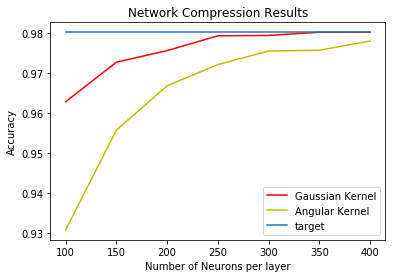

In [101]:
Best_Gauss = np.array([0.9628, 0.9727, 0.9756, 0.9793, 0.9794, 0.9802, 0.9802])
Best_ang = np.array(data_a["accuracy"])
Best = np.array([0.9802 for i in range(7)])
x = np.array([100, 150, 200, 250, 300, 350, 400])
plt.plot(x, Best_Gauss, color = 'r', label = "Gaussian Kernel")
plt.plot(x, Best_ang, color = 'y', label = "Angular Kernel")
plt.xlabel("Number of Neurons per layer")
plt.ylabel("Accuracy")
plt.plot(x, Best, label = "target")
plt.legend()
plt.title("Network Compression Results")
plt.show()

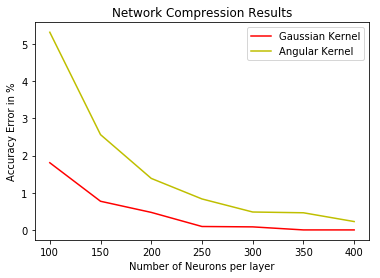

In [100]:
Best_Gauss = 100 * np.array([(0.9802 - 0.9628)/0.9628, (0.9802 - 0.9727)/ 0.9727, (0.9802 - 0.9756)/0.9756
                       , (0.9802 - 0.9793)/0.9793, (0.9802 - 0.9794)/0.9794, 0, 0])
Best_ang = 100 * np.array((0.9802 - data_a["accuracy"])/data_a["accuracy"])
x = np.array([100, 150, 200, 250, 300, 350, 400])
plt.plot(x, Best_Gauss, color = 'r', label = "Gaussian Kernel")
plt.plot(x, Best_ang, color = 'y', label = "Angular Kernel")
plt.xlabel("Number of Neurons per layer")
plt.ylabel("Accuracy Error in %")
plt.legend()
plt.title("Network Compression Results")
plt.show()